# Machine Learning Pipeline - Should this be a challenge?

**[Big Data and Cloud Computing]**

## Group D
* Daniela Tomás, up202004946
* Diogo Nunes, up202007895
* Diogo Almeida, up202006059

* https://stackoverflow.com/questions/59659344/how-to-process-faster-on-gz-files-in-spark-scala

## Data Understanding and Preparation

Firstly, we import the necessary libraries, packages and methods.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

Since the dataset is too large (4.2 Gigabytes compressed), we load it into Spark. However, it is inefficient to process gzip-compressed CSV files directly with Spark due to their non-splittable nature, and using an unziped CSV file is not always splittable. As shown in the code below, the CSV file took over 7 minutes to run, which is a considerable time.

```spark.read.csv``` evaluates lazily, which means that the read only occurs when an action is called.

In [11]:
spark = SparkSession.builder \
    .appName("Read CSV") \
    .getOrCreate()

file_path = "dataset/CHARTEVENTS.csv"

df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("delimiter", ",") \
    .load(file_path)

df.printSchema()
df.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- STORETIME: timestamp (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: double (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)

+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+------+----------+-------+----------+------+-------------------+-------------------+

To improve performance, we load the dataset into Spark using the Parquet file format with Snappy compression, ensuring splittable and efficient parallel processing across multiple nodes in the cluster.

In [12]:
parquet_file_path = "dataset/CHARTEVENTS.parquet"

df.write.format("parquet") \
    .option("compression", "snappy") \
    .save(parquet_file_path)

spark.stop()

Now it runs in about 25 seconds, which is much better. Parquet is columnar storage, which means it organizes data by columns rather than by rows, and this difference affects how data is displayed.

In [2]:
spark = SparkSession.builder \
    .appName("ICU_Length_of_Stay_Prediction") \
    .getOrCreate()

file_path = "dataset/CHARTEVENTS.parquet"

df = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

df.printSchema()
df.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- STORETIME: timestamp (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: double (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)

+-------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
| ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+-------+----------+-------+----------+------+-------------------+-----------------

In [6]:
print(f'{df.count()} rows and {len(df.columns)} cols')

330712483 rows and 15 cols


In [4]:
df.describe("VALUENUM").show()

+-------+------------------+
|summary|          VALUENUM|
+-------+------------------+
|  count|         146504168|
|   mean| 71.82548549626641|
| stddev|2047.6643228137305|
|    min|          -10069.0|
|    max|         9999999.0|
+-------+------------------+



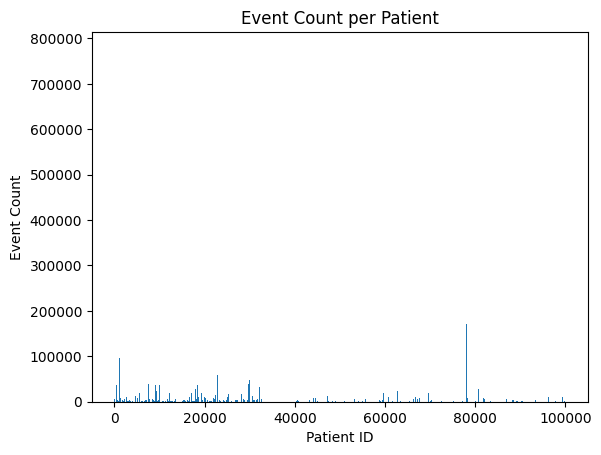

In [3]:
event_count_per_patient = df.groupBy("SUBJECT_ID").agg(count("*").alias("total_events")).collect()

patient_ids = [row["SUBJECT_ID"] for row in event_count_per_patient]
event_counts = [row["total_events"] for row in event_count_per_patient]

plt.bar(patient_ids, event_counts)
plt.xlabel("Patient ID")
plt.ylabel("Event Count")
plt.title("Event Count per Patient")
plt.show()

### Distribution of ICU stay lengths (LOS)

In [18]:
los_df = df.groupBy("ICUSTAY_ID") \
    .agg(
        min("CHARTTIME").alias("admission_time"),
        max("CHARTTIME").alias("discharge_time")
    ) \
    .withColumn("LOS_hours", ((unix_timestamp("discharge_time") - unix_timestamp("admission_time")) / 3600).cast("int"))

los_df.show(5)

+----------+-------------------+-------------------+---------+
|ICUSTAY_ID|     admission_time|     discharge_time|LOS_hours|
+----------+-------------------+-------------------+---------+
|    202251|2130-05-19 23:12:00|2130-05-21 12:17:00|       37|
|    279120|2179-06-18 04:25:00|2179-06-19 17:14:00|       36|
|    212175|2130-02-17 02:09:00|2130-02-18 22:47:00|       44|
|    257981|2153-01-25 17:38:00|2153-01-26 23:45:00|       30|
|    250386|2116-03-24 16:48:00|2116-03-26 18:21:00|       49|
+----------+-------------------+-------------------+---------+
only showing top 5 rows



In [19]:
los_df.describe("LOS_hours").show()

+-------+------------------+
|summary|         LOS_hours|
+-------+------------------+
|  count|             60841|
|   mean|131.42315215068786|
| stddev|3833.9851136288808|
|    min|                 0|
|    max|            944163|
+-------+------------------+



### Missing Values

In [20]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|CHARTTIME|STORETIME|   CGID|  VALUE| VALUENUM| VALUEUOM|  WARNING|    ERROR|RESULTSTATUS|  STOPPED|
+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+
|     0|         0|      0|    297529|     0|        0|  6312672|6312672|2071349|184208315|213982888|221315841|221315841|   321182823|110282285|
+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+



### Duplicate Values

In [ ]:
#duplicate_rows_count = df.count() - df.distinct().count()

In [7]:
df.groupBy(df.columns)\
    .count()\
    .where(col('count') > 1)\
    .select(sum('count'))\
    .show()

ConnectionRefusedError: [WinError 10061] Nenhuma ligação pôde ser feita porque o computador de destino
as recusou ativamente

In [ ]:
spark.stop()